In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
import plotly.express as px

fig_DIR = "../figs/team_leaders/"

In [2]:
import os
os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.3.2\\"
%reload_ext rpy2.ipython

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


# Net Ratings

In [3]:
def get_df(stats):
    df = stats.get_data_frames()[0]
    df["Team"] = df["TEAM_NAME"]
    cols = df.columns
    df.columns = cols.str.replace("RATING","RTG")
    return df

In [4]:
from nba_api.stats.endpoints import leaguedashteamstats
stats = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense="Advanced")
df = get_df(stats)
df = df.rename(columns={"OFF_RTG_RANK":"O_RANK","DEF_RTG_RANK":"D_RANK"})

In [5]:
df.columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RTG',
       'OFF_RTG', 'E_DEF_RTG', 'DEF_RTG', 'E_NET_RTG', 'NET_RTG', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT',
       'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'O_RANK',
       'D_RANK', 'NET_RTG_RANK', 'AST_PCT_RANK', 'AST_TO_RANK',
       'AST_RATIO_RANK', 'OREB_PCT_RANK', 'DREB_PCT_RANK', 'REB_PCT_RANK',
       'TM_TOV_PCT_RANK', 'EFG_PCT_RANK', 'TS_PCT_RANK', 'PACE_RANK',
       'PIE_RANK', 'Team'],
      dtype='object')

In [6]:
df1 = df.sort_values(by="NET_RTG",ascending=False)
df1 = df1.reset_index(drop=True)
df1 = df1.reset_index(drop=False)
df1["#"] = df1["index"] +1
df2 = df1[["#","Team","OFF_RTG","O_RANK","DEF_RTG","D_RANK","NET_RTG"]]
df = df2

In [7]:
n_colors = 30
colors = px.colors.sample_colorscale("Tropic", [n/(n_colors -1) for n in range(n_colors)])
orank = df["O_RANK"]-1
orank = orank.astype(np.int32).to_numpy()
carray_o =  np.array(colors)[orank]
drank = df["D_RANK"]-1
drank = drank.astype(np.int32).to_numpy()
carray_d =  np.array(colors)[drank]
nrank = df["#"]-1
nrank = nrank.astype(np.int32).to_numpy()
carray_n =  np.array(colors)[nrank]
title = "NBA Net Rating Leaders 2023-24"
font = dict(color="black",family="Arial Black, monospace", size=11)
fig = go.Figure(data=[go.Table(
        columnwidth=[5,50,15,15,15,15,15],
        header=dict(values=list(df.columns),
                    fill_color='snow',
                    align=['center','left','center','center'],
                    font=dict(color='Black',family="Arial Black, monospace", size=12),
                    line_color="grey"
                    ),
        cells=dict(values=[df["#"],df["Team"],df["OFF_RTG"],df["O_RANK"],df["DEF_RTG"],
                           df["D_RANK"],df["NET_RTG"]],
                fill_color=["white","white",carray_o,"white",carray_d,"white",carray_n],
                align=['center','left','center','center'],
                height=23,
                line_color="grey",#lightgrey",
                font=font,
                ),
                # height=25
        ),
    ])
    # fig.update_layout(title_text=title)
fig.update_layout(title=dict(text=title,y=0.99,x=0.1,font=dict(size=15,family="Arial Black, monospace")))
fig.add_annotation(x=0.0, y=0.0,text="@SravanNBA",showarrow=False,xshift=1,yshift=5)
fig.add_annotation(x=1.0, y=0.0,text="Source: nba.com/stats",showarrow=False,xshift=1,yshift=5,font=dict(size=10))
# fig.update_layout(title=dict(text=title,y=0.01,x=0.1,font=dict(size=15,family="Arial Black, monospace")))
tab_width = 550 
tab_height = 770
fig.update_layout(width=tab_width,height=tab_height,margin=dict(t=25,b=1,l=1,r=1))
# fig.update_layout(autosize=True)
fig.show()
fig.write_image(fig_DIR+f"Teams_NET_RTG.png", scale=3)

In [8]:
%%R -i df 
library(tidyverse)
library(gt)

df %>% 
  gt()%>%
  tab_header(
    title = md("**NBA Net Rating Leaders 2023-24**")) %>%
    data_color(columns = OFF_RTG, palette = c("red", "green")) %>%
    data_color(columns = DEF_RTG, palette = c("green","red")) %>%
    data_color(columns = NET_RTG, palette = c("red", "green")) %>%
    cols_align(align = "center",columns = c("#",OFF_RTG,O_RANK,DEF_RTG,D_RANK,NET_RTG))  %>%
    tab_options(
        table.background.color = "floralwhite",
        column_labels.font.size = 12,
        column_labels.font.weight = 'bold',
        row_group.font.weight = 'bold',
        row_group.background.color = "#E5E1D8",
        table.font.size = 10,
        heading.title.font.size = 20,
        heading.subtitle.font.size = 12.5,
        table.font.names = "Consolas", 
        data_row.padding = px(2)
    ) %>% 
    tab_source_note(
    source_note = "@SravanNBA | Source: nba.com/stats" ) #%>% gtsave("../figs/R/Teams_NET_RTG.png",zoom=5) 


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Team Shooting Splits

In [ ]:
from nba_api.stats.endpoints import leaguedashteamshotlocations

In [ ]:
stats = leaguedashteamshotlocations.LeagueDashTeamShotLocations(distance_range="8ft Range",per_mode_detailed = "PerGame")
df = stats.get_data_frames()[0]
df1 = pd.DataFrame()
df1["tID"] = df[""]["TEAM_ID"]
df1["Team"] = df[""]["TEAM_NAME"]
df1["r00_8"]  = df["Less Than 8 ft."]["FGA"]
df1["r08_16"]  = df["8-16 ft."]["FGA"]
df1["r16_24"]  = df["16-24 ft."]["FGA"]
df1["r24_"]  = df["24+ ft."]["FGA"]
df1["sum"] = df1.iloc[:,-4:].sum(axis=1)
df1.iloc[:,-5:-1] = df1.iloc[:,-5:-1].div(df1["sum"],axis=0)*100
df1.iloc[:,-5:-1] = df1.iloc[:,-5:-1].round(2)
df1 = df1.drop(["sum"],axis=1)
data = df1
data.to_csv("../R/fdata" +"nba_team_shooting_splits.csv")

# Rolling Ratings

In [12]:
from nba_api.stats.endpoints import leaguegamelog

In [13]:
season = 2023
df1 = pd.read_csv(f"./boxscores/NBA_BoxScores_Adv_{season}.csv")
cols = ["gameId","teamId","offensiveRating","defensiveRating","netRating","possessions"]
df1 = df1[cols]
stats = leaguegamelog.LeagueGameLog(player_or_team_abbreviation="T",season=season,season_type_all_star="Regular Season")
df2 = stats.get_data_frames()[0]

df2 = df2.rename(columns={"GAME_ID":"gameId","TEAM_ID":"teamId","TEAM_ABBREVIATION":"teamTricode","GAME_DATE":"gameDate","TEAM_NAME":"teamName"})
cols2 = ["gameId","teamId","teamTricode","gameDate"]
df2 = df2[cols2]
df2["gameId"] = df2["gameId"].astype(int)
df3 = pd.merge(df2,df1,on=["gameId","teamId"])
df4 = df3.sort_values(by=["teamTricode","gameDate"]).reset_index(drop=True)
df6 = df3.sort_values(by=["gameDate"]).reset_index(drop=True)
teams = df6["teamTricode"].unique()

In [14]:
dfa = []
for team in teams:
    df5 = df4[df4["teamTricode"]==team].reset_index(drop=True)
    df5["oPts"] = df5["offensiveRating"]*df5["possessions"]
    df5["dPts"] = df5["defensiveRating"]*df5["possessions"]
    df5["roPts"]=df5["oPts"].cumsum()
    df5["rdPts"]=df5["dPts"].cumsum()
    df5["rPoss"]=df5["possessions"].cumsum()
    df5["rORtg"]=df5["roPts"] / df5["rPoss"]
    df5["rDRtg"]=df5["rdPts"] / df5["rPoss"]
    df5["rNRtg"] = df5["rORtg"] - df5["rDRtg"]
    df5["rORtg"] = df5["rORtg"].round(2)
    df5["rDRtg"] = df5["rDRtg"].round(2)
    df5["rNRtg"] = df5["rNRtg"].round(2)
    dfa.append(df5)
data = pd.concat(dfa)
data["teamDup"] = data["teamTricode"]
data = data.rename(columns={"gameDate":"Date"})
# data[data["Date"]>"2023-11-07"]
data1 = data.copy()
data1 = data1.drop(columns=["teamTricode"])

In [15]:
dates = df4["gameDate"].unique()
dfb = []
for date in dates:
    df7 = df6[df6["gameDate"]<=date].reset_index(drop=True)
    df7["oPts"] = df7["offensiveRating"]*df7["possessions"]
    df7["dPts"] = df7["defensiveRating"]*df7["possessions"]
    df7["roPts"]=df7["oPts"].cumsum()
    df7["rdPts"]=df7["dPts"].cumsum()
    df7["rPoss"]=df7["possessions"].cumsum()
    df7["rORtg"]=df7["roPts"] / df7["rPoss"]
    df7["rDRtg"]=df7["rdPts"] / df7["rPoss"]
    df7["rNRtg"] = df7["rORtg"] - df7["rDRtg"]
    df7["rORtg"] = df7["rORtg"].round(2)
    df7["rDRtg"] = df7["rDRtg"].round(2)
    df7["rNRtg"] = df7["rNRtg"].round(2)
    dfb.append(df7.tail(1))
data_avg = pd.concat(dfb).reset_index(drop=True)
data_avg = data_avg.rename(columns={"gameDate":"Date"})
data_avg["teamTricode"] = "avg"
data_avg["teamDup"] = data_avg["teamTricode"]
data_avg = data_avg.drop(columns=["teamTricode"])

In [16]:
from plotnine import ggplot, aes, geom_line,geom_point,geom_smooth,geom_hline,scale_color_manual,ggsave,themes,labs,element_rect,element_blank,theme,element_text,facet_wrap,scale_y_continuous, ylim, scale_x_date
theme_sra = themes.theme_minimal(base_size=9, base_family="Tahoma")

## OFF

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/team_leaders/Rolling ORtg.png
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 30 rows containing missing values.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 1 rows containing missing values.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 30 rows containing missing values.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-

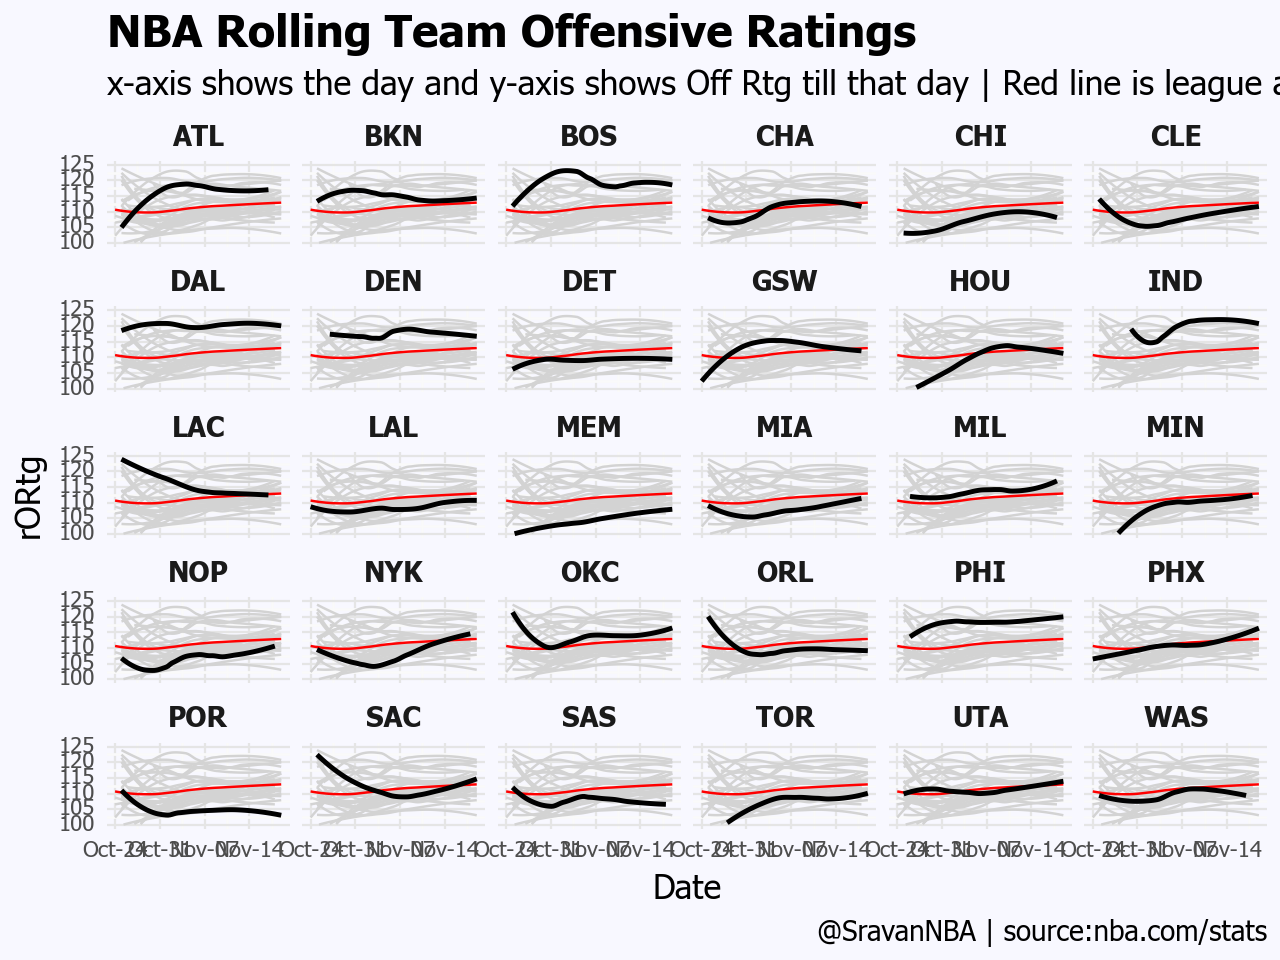

In [17]:
p = (
    ggplot(data)
    + geom_smooth(data= data1,mapping= aes(x="Date", y="rORtg",group = "teamDup") ,method="loess",color="lightgrey", se=False, size=0.5) 
    + geom_smooth(data= data_avg,mapping=aes(x="Date", y="rORtg",group = "teamDup"),method="loess",color="red", se=False, size=0.5) 
    + geom_smooth(aes(x="Date", y="rORtg",group= "teamTricode"),method="loess",color="Black", se=False, size=1) 
    + ylim(100, 125)
    + scale_x_date(date_labels = "%b-%d",date_breaks = "1 week")
    + labs(
       title = "NBA Rolling Team Offensive Ratings",
       subtitle = "x-axis shows the day and y-axis shows Off Rtg till that day | Red line is league avg Off Rtg",
       caption = "@SravanNBA | source:nba.com/stats")
    + facet_wrap(facets="~ teamTricode")
    + theme_sra
    + theme(
    #   panel_grid_minor = element_blank(),
    #   panel_grid_major = element_blank(),
      plot_background = element_rect(fill = 'ghostwhite', color = "ghostwhite"))
    + theme(
            plot_title = element_text(face = 'bold',size=16),
            strip_text = element_text(face = 'bold',size=10),
            plot_caption = element_text(size=10),
            plot_subtitle = element_text(size=12)
        )
    + theme(axis_text_x = element_text(size=8),
        axis_text_y = element_text(size=8),
        axis_title_x = element_text(size=12),
        axis_title_y = element_text(size=12)) 
    # + geom_hline(yintercept=30, linetype="dashed", color="black", size=0.5) 
)
p.save("../figs/team_leaders/" +"Rolling ORtg.png",width=10,height=10,dpi=300)
p.draw()

## DEF

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/team_leaders/Rolling DRtg.png


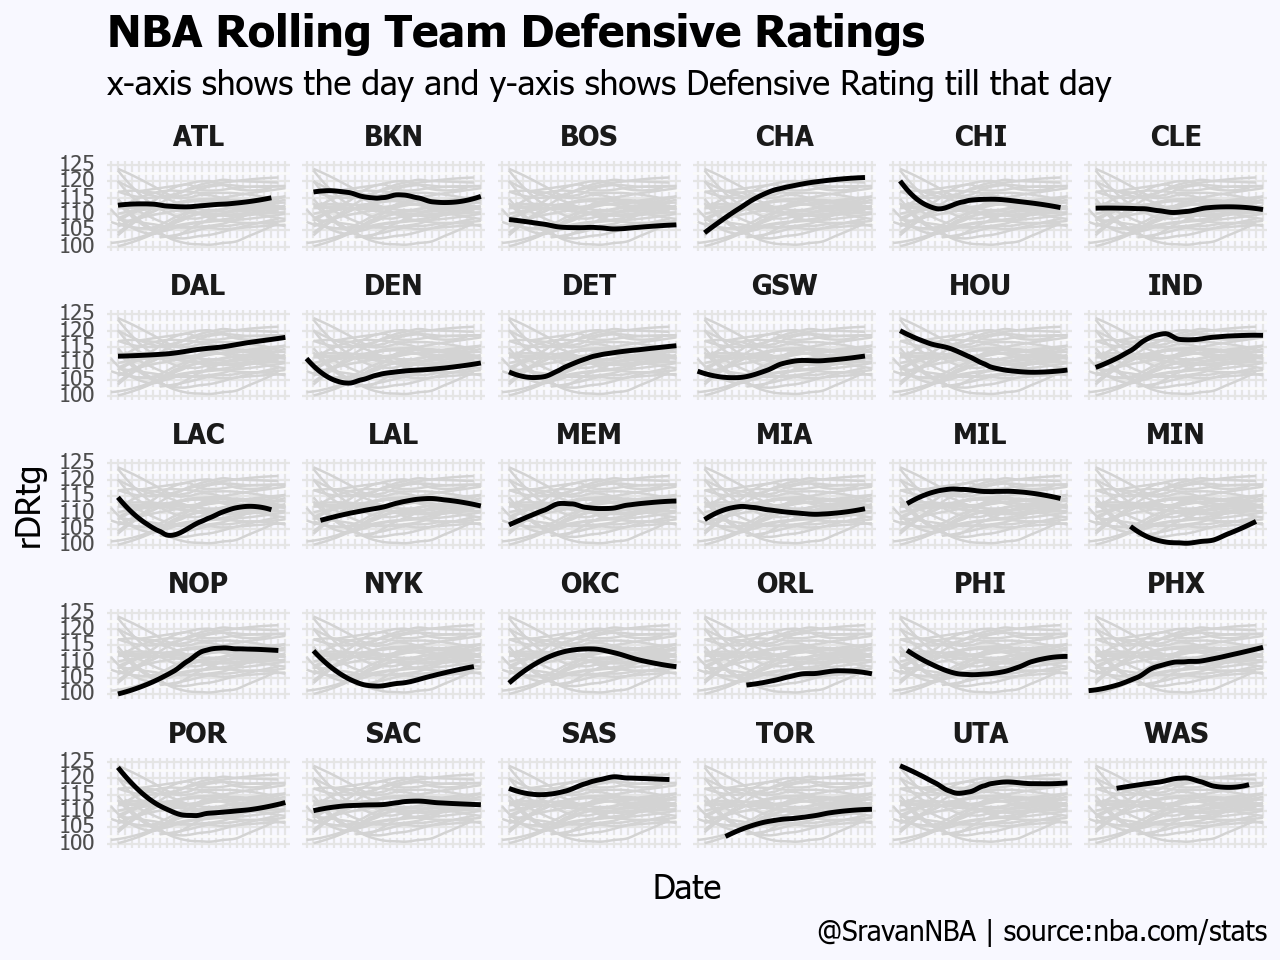

In [18]:
p = (
    ggplot(data) 
    + geom_smooth(data= data1,mapping= aes(x="Date", y="rDRtg",group = "teamDup") ,method="loess",color="lightgrey", se=False, size=0.5) 
    + geom_smooth(aes(x="Date", y="rDRtg",group= "teamTricode"),method="loess",color="Black", se=False, size=1) 
    + ylim(100, 125)
    + labs(
       title = "NBA Rolling Team Defensive Ratings",
       subtitle = "x-axis shows the day and y-axis shows Defensive Rating till that day",
       caption = "@SravanNBA | source:nba.com/stats")
    + facet_wrap(facets="~ teamTricode")
    + theme_sra
    + theme(
    #   panel_grid_minor = element_blank(),
    #   panel_grid_major = element_blank(),
      plot_background = element_rect(fill = 'ghostwhite', color = "ghostwhite"))
    + theme(
            plot_title = element_text(face = 'bold',size=16),
            strip_text = element_text(face = 'bold',size=10),
            plot_caption = element_text(size=10),
            plot_subtitle = element_text(size=12)
        )
    + theme(axis_text_x = element_blank(),
        axis_text_y = element_text(size=8),
        axis_title_x = element_text(size=12),
        axis_title_y = element_text(size=12)) 
    # + geom_hline(yintercept=30, linetype="dashed", color="black", size=0.5) 
)
p.save("../figs/team_leaders/" +"Rolling DRtg.png",width=10,height=10,dpi=300)
p.draw()

## NET

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/team_leaders/Rolling NRtg.png
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 60 rows containing missing values.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 2 rows containing missing values.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 60 rows containing missing values.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-

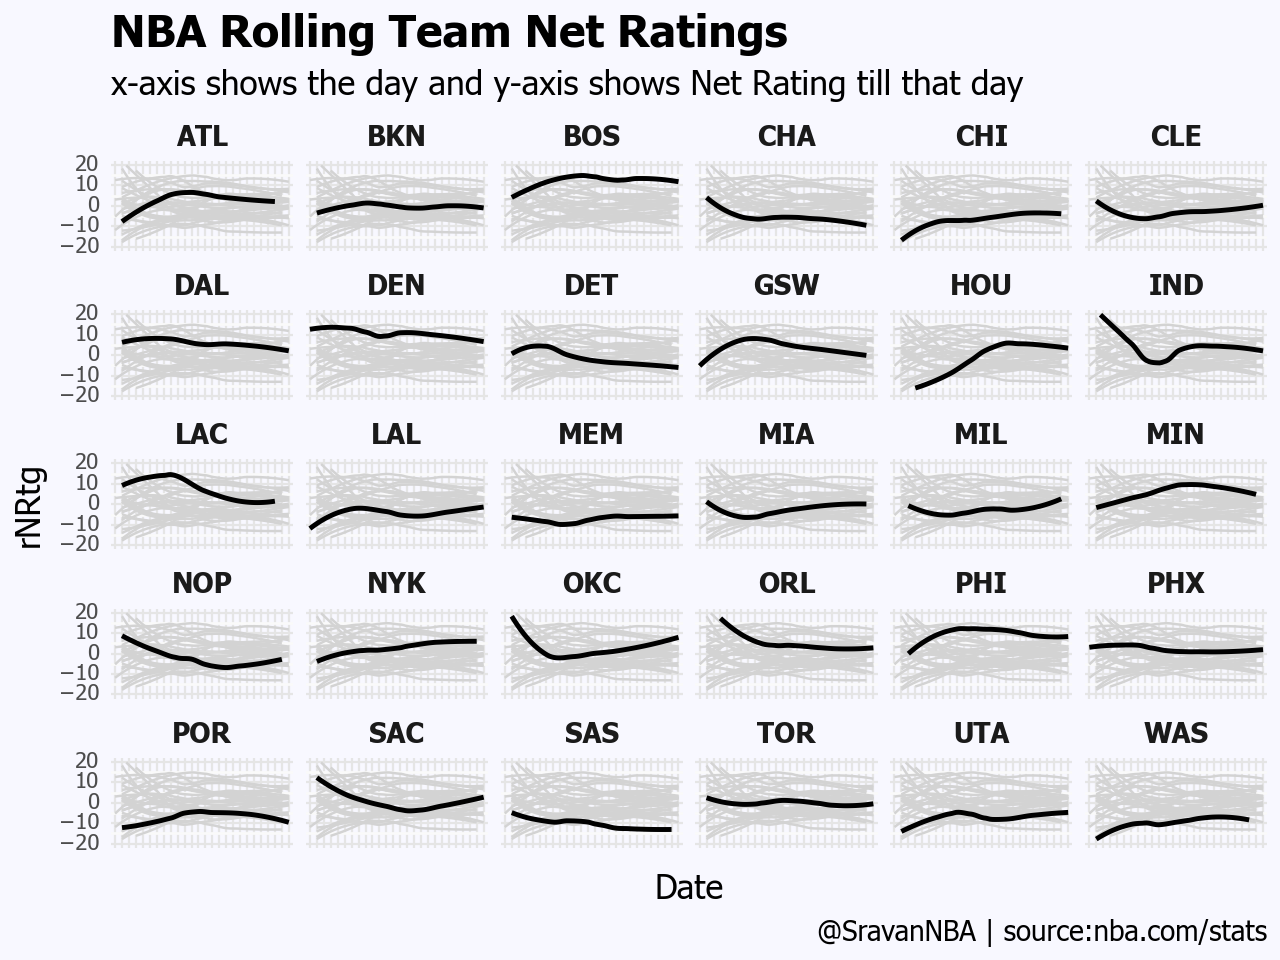

In [19]:
p = (
    ggplot(data)  
    + geom_smooth(data= data1,mapping= aes(x="Date", y="rNRtg",group = "teamDup") ,method="loess",color="lightgrey", se=False, size=0.5) 
    + geom_smooth(aes(x="Date", y="rNRtg",group= "teamTricode"),method="loess",color="Black", se=False, size=1) 
    + ylim(-20, 20)
    + labs(
       title = "NBA Rolling Team Net Ratings",
       subtitle = "x-axis shows the day and y-axis shows Net Rating till that day",
       caption = "@SravanNBA | source:nba.com/stats")
    + facet_wrap(facets="~ teamTricode")
    + theme_sra
    + theme(
    #   panel_grid_minor = element_blank(),
    #   panel_grid_major = element_blank(),
      plot_background = element_rect(fill = 'ghostwhite', color = "ghostwhite"))
    + theme(
            plot_title = element_text(face = 'bold',size=16),
            strip_text = element_text(face = 'bold',size=10),
            plot_caption = element_text(size=10),
            plot_subtitle = element_text(size=12)
        )
    + theme(axis_text_x = element_blank(),
        axis_text_y = element_text(size=8),
        axis_title_x = element_text(size=12),
        axis_title_y = element_text(size=12)) 
    # + geom_hline(yintercept=30, linetype="dashed", color="black", size=0.5) 
)
p.save("../figs/team_leaders/" +"Rolling NRtg.png",width=10,height=10,dpi=300)
p.draw()

## TEAM

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/team_leaders/Rolling ORtg MEM.png


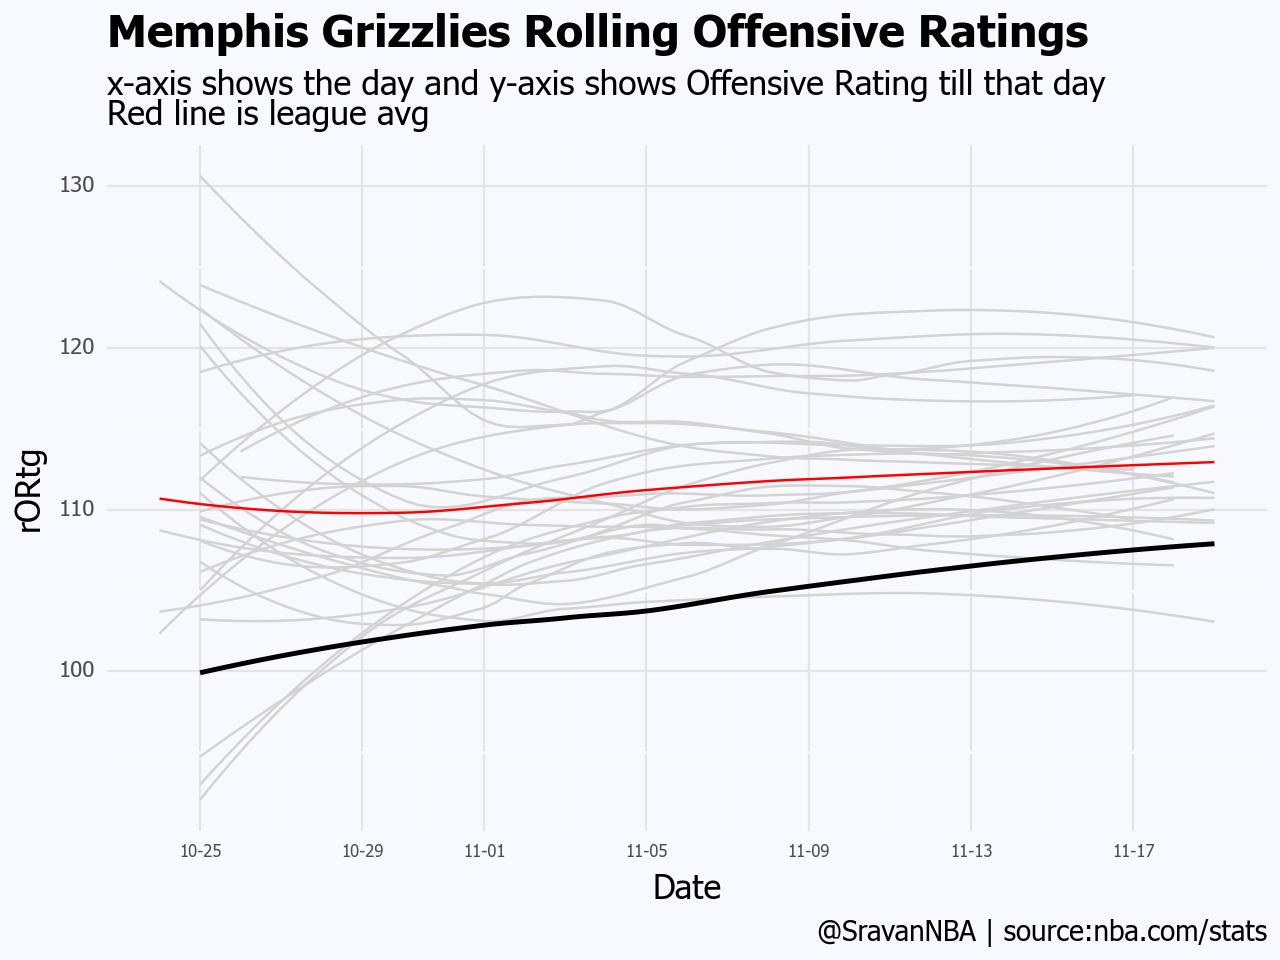

In [20]:
team = "MEM"
data2 = data[data["teamTricode"]==team]
p = (
    ggplot(data2)
    + geom_smooth(data= data1,mapping= aes(x="Date", y="rORtg",group = "teamDup") ,method="loess",color="lightgrey", se=False, size=0.5) 
    + geom_smooth(data= data_avg,mapping=aes(x="Date", y="rORtg",group = "teamDup"),method="loess",color="red", se=False, size=0.5) 
    + geom_smooth(aes(x="Date", y="rORtg",group= "teamTricode"),method="loess",color="Black", se=False, size=1) 
    + scale_x_date(date_labels = "%m-%d")
    # + ylim(100, 130)
    + labs(
       title = "Memphis Grizzlies Rolling Offensive Ratings",
       subtitle = "x-axis shows the day and y-axis shows Offensive Rating till that day\nRed line is league avg",
       caption = "@SravanNBA | source:nba.com/stats")
    + theme_sra
    + theme(
      plot_background = element_rect(fill = 'ghostwhite', color = "ghostwhite"))
    + theme(
            plot_title = element_text(face = 'bold',size=16),
            strip_text = element_text(face = 'bold',size=10),
            plot_caption = element_text(size=10),
            plot_subtitle = element_text(size=12)
        )
    + theme(axis_text_x = element_text(size=6),
        axis_text_y = element_text(size=8),
        axis_title_x = element_text(size=12),
        axis_title_y = element_text(size=12)) 
    # + geom_hline(yintercept=30, linetype="dashed", color="black", size=0.5) 
)
p.save("../figs/team_leaders/" +"Rolling ORtg "+team+".png",width=8,height=6,dpi=300)
p.draw()